## 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
import pickle
import requests
import json

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from scipy import stats as ss
from IPython.display import display, HTML
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)

### 1.1 Funções

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error (y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error (model, y, yhat):
    mae = mean_absolute_error(y,yhat) 
    mape= mean_absolute_percentage_error(y,yhat)
    rmse= mean_squared_error(y, yhat, squared=False)
    return pd.DataFrame({'Modelo': model, 'MAE': mae, "MAPE": mape, 'RMSE': rmse}, index=[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
            # Data de inicio e fim do cross validation
            validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
            validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
            
            # Filtragem do dataset
            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
            
            # Preparacao dado de Treino
            xtraining = training.drop( ['date', 'sales'], axis=1 )
            ytraining = training['sales']
           
            # Preparacao dado de Validacao
            xvalidation = validation.drop( ['date', 'sales'], axis=1 )
            yvalidation = validation['sales']
            
            # Treinamento do modelo
            m = model.fit( xtraining, ytraining )
            
            # Previsao
            yhat = m.predict( xvalidation )
            
            # Medicao da performance
            m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
            
            # Salvando em lista a performance do algoritmo em cada iteracao
            mae_list.append( m_result['MAE'] )
            mape_list.append( m_result['MAPE'] )
            rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


## 2.0 Carregamento dos dados

In [3]:
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)
df_test_raw = pd.read_csv("data/test.csv", low_memory=False)
df_train_raw = pd.read_csv("data/train.csv", low_memory=False)
df_sample_raw = pd.read_csv("data/sample_submission.csv", low_memory=False)

In [4]:
df_raw = df_train_raw.merge(df_store_raw, how='left', on='Store')

In [5]:
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## 3.0 Descrição de dados

In [6]:
df1 = df_raw.copy()

### 3.1 Renomear Colunas

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x:inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))
df1.columns = new_cols

### 3.2 Informações dos dados

In [9]:
df1.shape

(1017209, 18)

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 3.3 Preenchimento dos NA

In [12]:
#competition_distance: A premissa adotada é que  não existem competidores próximos da loja, de forma que substituiremos 
                        #os valores NA por valores muito altos
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if pd.isna(x) else x)

#competition_open_since_month: A premissa adotada é manter as linhas NA, porém usar o mês da venda daquela loja como data da
                                # abertura da concorrente.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year: A premissa adotada é manter as linhas NA, porém usar o mês da venda daquela loja como data da
                                # abertura da concorrente.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo_2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo_2                               int64
dtype: object

In [14]:
#Conversao de tipo de dados

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 3.4 Estátistica Descritiva

In [15]:
df1.describe(exclude=('object0'), datetime_is_numeric=True).apply(lambda s: s.apply('{0:.5f}'.format))

,store,day_of_week,date,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo_2
count,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000
mean,558.42973,3.99834,.5f,5773.81897,633.14595,0.83011,0.38151,0.17865,5935.44268,6.78685,2010.32484,0.50056,23.61903,2012.79330,0.15523
min,1.00000,1.00000,.5f,0.00000,0.00000,0.00000,0.00000,0.00000,20.00000,1.00000,1900.00000,0.00000,1.00000,2009.00000,0.00000
25%,280.00000,2.00000,.5f,3727.00000,405.00000,1.00000,0.00000,0.00000,710.00000,4.00000,2008.00000,0.00000,12.00000,2012.00000,0.00000
50%,558.00000,4.00000,.5f,5744.00000,609.00000,1.00000,0.00000,0.00000,2330.00000,7.00000,2012.00000,1.00000,22.00000,2013.00000,0.00000
75%,838.00000,6.00000,.5f,7856.00000,837.00000,1.00000,1.00000,0.00000,6910.00000,10.00000,2014.00000,1.00000,37.00000,2014.00000,0.00000
max,1115.00000,7.00000,.5f,41551.00000,7388.00000,1.00000,1.00000,1.00000,200000.00000,12.00000,2015.00000,1.00000,52.00000,2015.00000,1.00000
std,321.90865,1.99739,nan,3849.92618,464.41173,0.37554,0.48576,0.38306,12547.65300,3.31109,5.51559,0.50000,14.31006,1.66266,0.36212


In [16]:
df1.skew(numeric_only=True)

store                           -0.000955
day_of_week                      0.001593
sales                            0.641460
customers                        1.598650
open                            -1.758045
promo                            0.487838
school_holiday                   1.677842
competition_distance            10.242344
competition_open_since_month    -0.042076
competition_open_since_year     -7.235657
promo2                          -0.002255
promo2_since_week                0.178723
promo2_since_year               -0.784436
is_promo_2                       1.904152
dtype: float64

In [17]:
df1.kurtosis(numeric_only=True)

store                            -1.200524
day_of_week                      -1.246873
sales                             1.778375
customers                         7.091773
open                              1.090723
promo                            -1.762018
school_holiday                    0.815154
competition_distance            147.789712
competition_open_since_month     -1.232607
competition_open_since_year     124.071304
promo2                           -1.999999
promo2_since_week                -1.184046
promo2_since_year                -0.210075
is_promo_2                        1.625796
dtype: float64

## 4.0 Criação de Features

In [18]:
df2 = df1.copy()

### 4.1 Mapa mental de Hipóteses

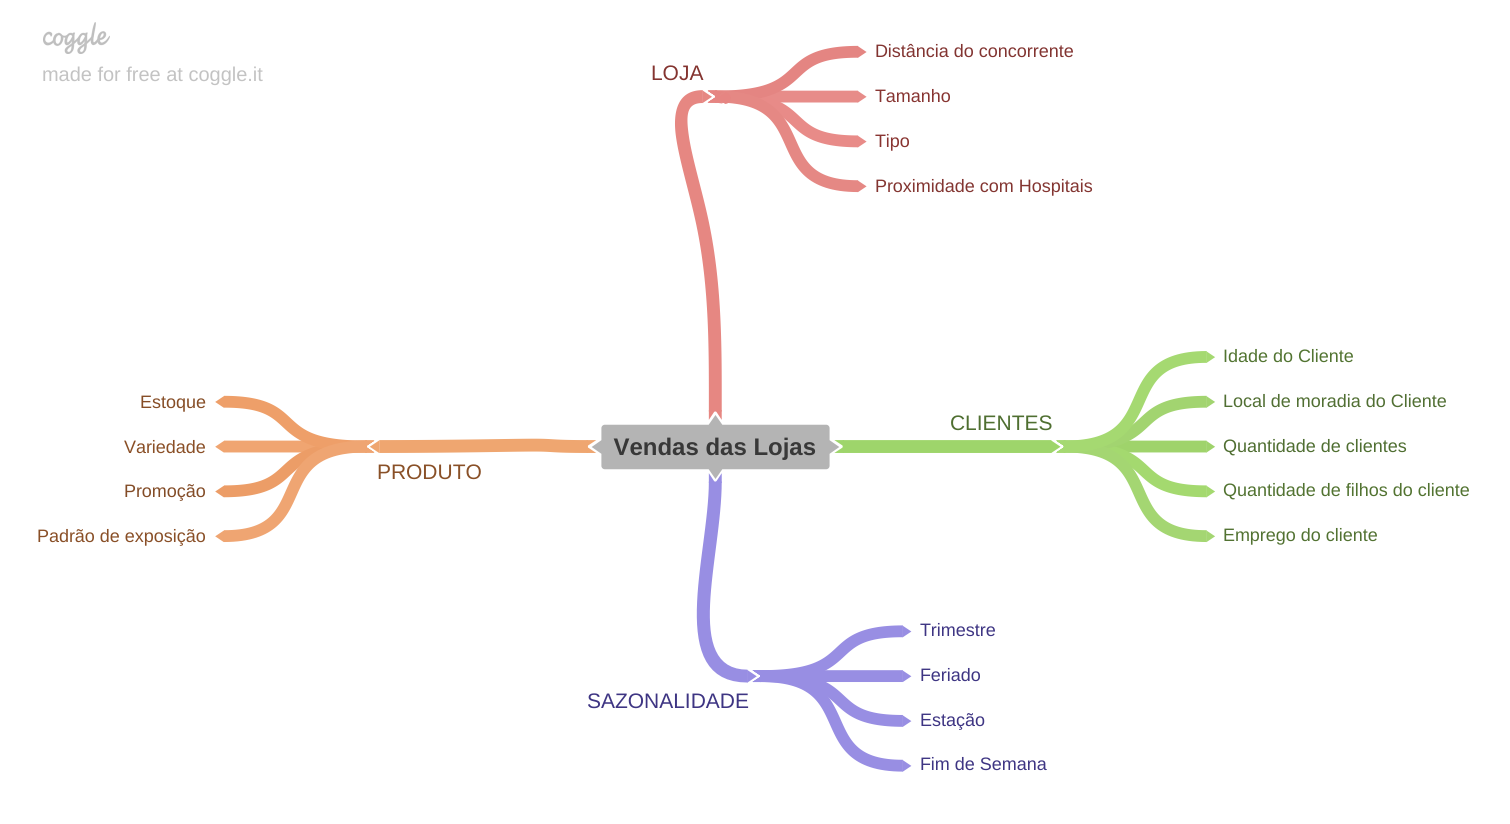

In [34]:
Image('img/Vendas_das_Lojas.png')

### 4.2 Criação de Hipóteses

#### Hipóteses de Sazonalidade

**1.** Ocorrem mais vendas no inverno.

**2.** Ocorrem menos vendas no fim de semana.

**3.** As vendas crescem anualmente.

**4.** As vendas diminuem em feriados.

#### Hipóteses de Produto

**1.** Lojas com mais estoque vendem mais.

**2.** Lojas com itens em promoção vendem mais.

**3.** Lojas com promoções consecutivas vendem mais.

**4.** Lojas com menor variedade de produtos vendem menos.

**5.** Lojas com determinado padrão de exposição de produtos vendem mais.

#### Hipóteses de Loja

**1.** Lojas com concorrentes mais próximos vendem menos.

**2.** Lojas maiores vendem mais.

**3.** Lojas proximas a hospitais vendem mais.

**4.** Os tipos de loja influênciam na quantidade de vendas.

**5.** Lojas com competidores à mais tempo deveriam vendem mais.

#### Hipóteses de Clientes

**1.** Clientes mais velhos compram mais.

**2.** Clientes que moram mais perto compram mais.

**3.** Clientes com mais filhos compram mais.

**4.** Clientes com determinado emprego compram menos.

#### Lista final de hipóteses a serem validadas

**1.** Ocorrem mais vendas no inverno.

**2.** Ocorrem menos vendas no fim de semana.

**3.** As vendas crescem anualmente.

**4.** As vendas diminuem em feriados.

**5.** Lojas com itens em promoção vendem mais.

**6.** Lojas com promoções consecutivas vendem mais.

**7.** Lojas com menor variedade de produtos vendem menos. _Hipótese alterada para tipo de Sortimento, devido aos dados que possuimos neste dataset._

**8.** Lojas com concorrentes mais próximos vendem menos.

**9.** Os tipos de loja influênciam na quantidade de vendas.

**10.** Lojas com competidores à mais tempo deveriam vendem mais.

### Feature Engineering

In [19]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year_week
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

#competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#promo2_since
df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

#season
spring = range(79, 172)
summer = range(172, 266)
fall = range(266, 355)
df2['season'] = df2['date'].apply(lambda x: 'spring' if x.timetuple().tm_yday in spring else 'summer' if x.timetuple().tm_yday in summer else 'fall' if x.timetuple().tm_yday in fall else 'winter' )


In [36]:
df2

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo_2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo_time_week,season
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,summer
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,summer
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,summer
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,summer
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,basic,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30,winter
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,extended,1880.0,4,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0,winter
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,9260.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0,winter
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,870.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0,winter


## 5.0 Filtragem de Variáveis 

In [20]:
df3 = df2.copy()

In [21]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo_2',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo2_since',
       'promo_time_week', 'season'],
      dtype='object')

### 5.1 Filtragem de Linhas

In [22]:
#Filtrando linhas onde a loja está fechada e também onde as vendas foram 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 5.2 Seleção de Colunas

In [23]:
#Filtrando colunas que não teremos no momento da previsão ou que foram colunas auxiliares na criação de váriaveis
df3 = df3.drop(['customers','open','promo_interval','month_map'], axis=1)

## 6.0 Análise exploratória dos dados

In [24]:
df4 = df3.copy()

### 6.1 Análise Univariada

#### 6.1.1 Variável Resposta

<Axes: xlabel='sales', ylabel='Count'>

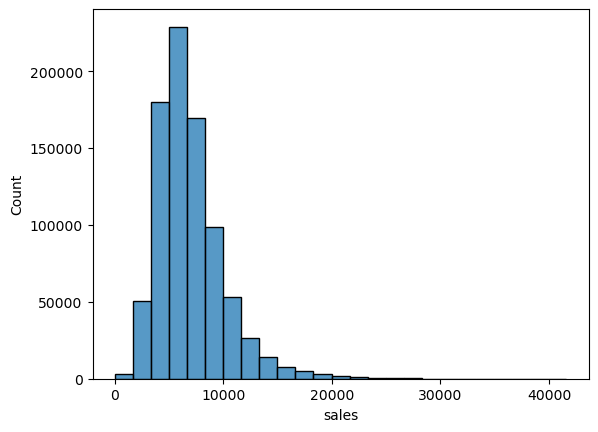

In [42]:
sns.histplot(df4['sales'], bins= 25)

#### 6.1.2 Variáveis Númericas

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df4.select_dtypes(include=numerics)

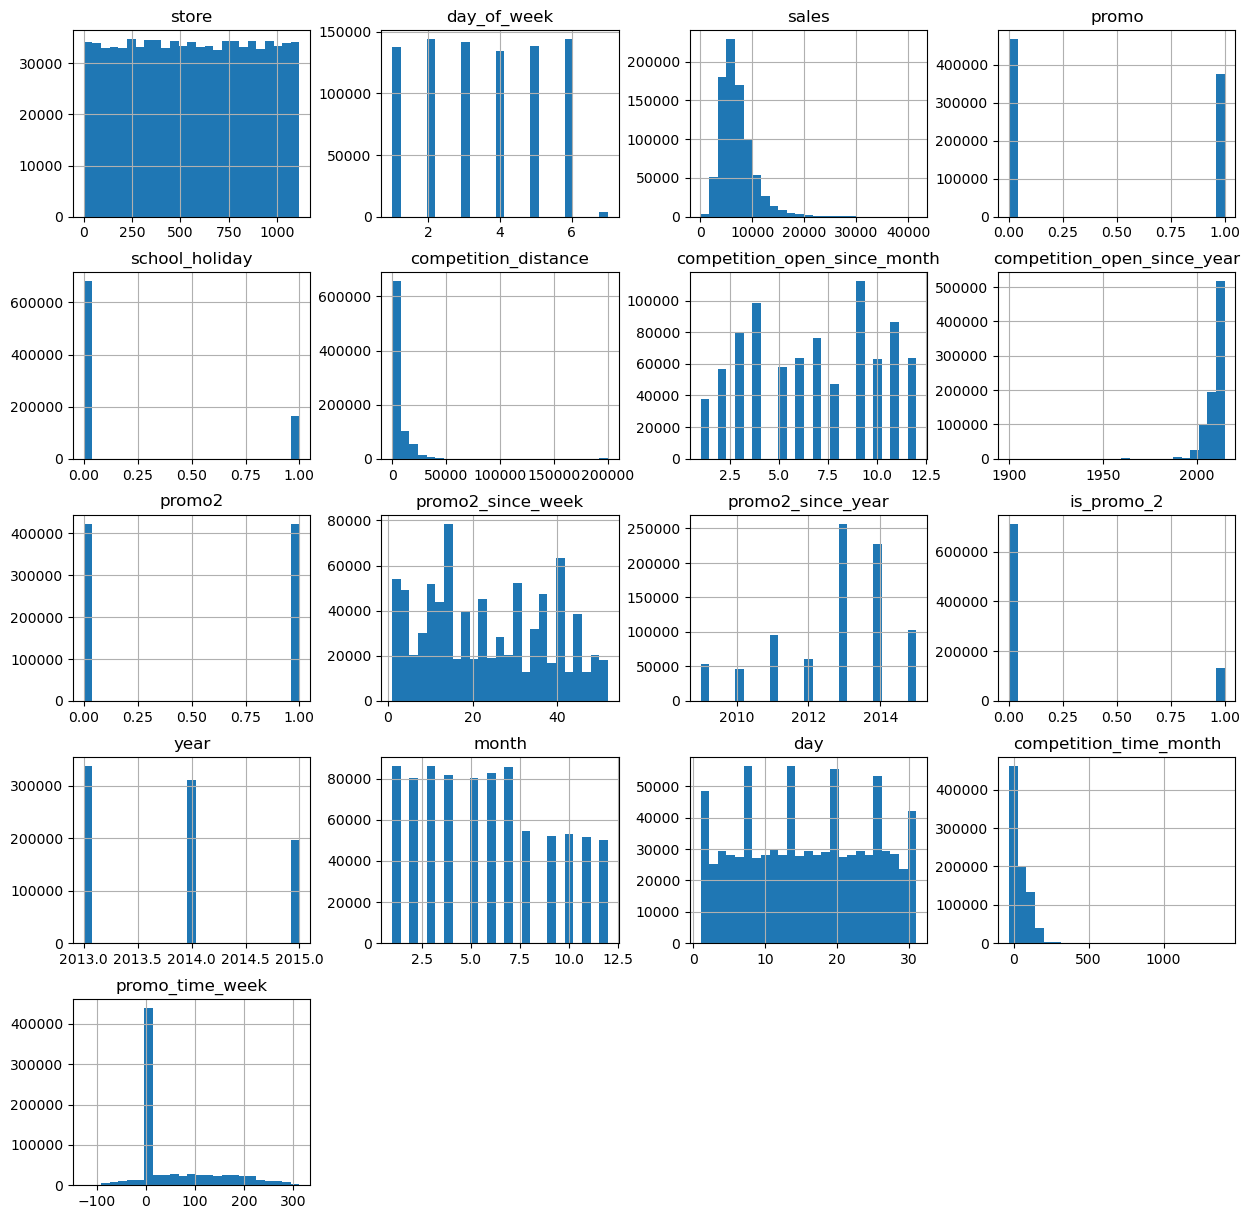

In [44]:
df_numeric.hist(bins=25, figsize=[15,15]);

**Descobertas:**

**1.** Existe uma queda do registro de vendas no dia 7 da semana, a causa aparente é que muitas lojas estão fechadas

**2.** Existem mais registros de vendas fora de feriados escolares

**3.** Existem muitas lojas com competidores próximos

**4.** A feature competition_open_since_month aparenta ter um comportamento definido

**5.** Existem mais registros de vendas fora da promo2, isso pode se dar ao fato que nem todas as lojas participaram da promo2

**6.** Os registro de vendas vem caindo ao longo dos anos

**7.** Os registro de vendas no ultimo trismestre são menores

**8.** A feature days aparenta ter um comportamento definido


#### 6.1.3 Variáveis Categóricas

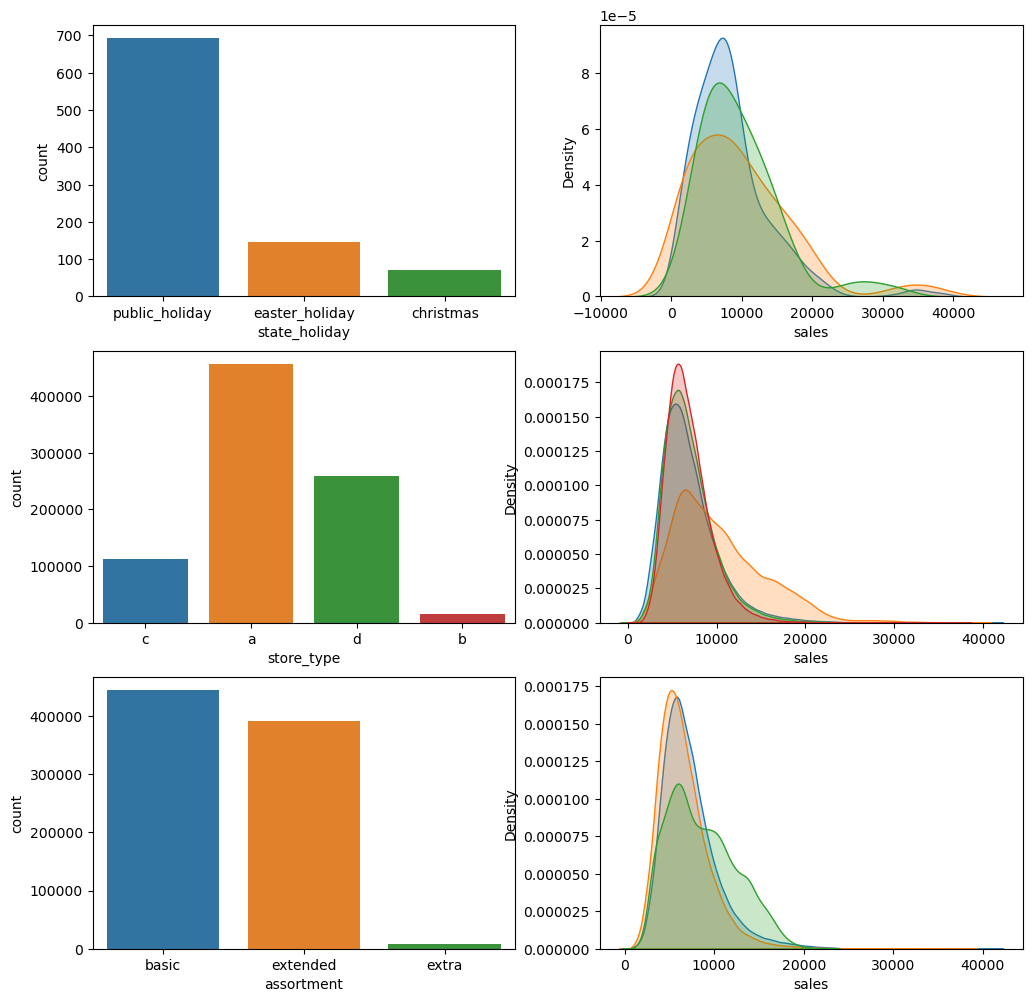

In [45]:
# state_holiday

f = plt.figure(figsize=(12,12))

f.add_subplot(321)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x= a['state_holiday'] )

f.add_subplot(322)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )

# store_type
f.add_subplot(323)
sns.countplot( x=df4['store_type'] )

f.add_subplot(324)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
f.add_subplot(325)
sns.countplot( x=df4['assortment'] )

f.add_subplot(326)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',fill=True )

plt.show(f)

### 6.2 Análise Bivariada

**Hipótese 1.** Ocorrem mais vendas no inverno.

**FALSA:** A estação do ano que mais vende é a estação fall (outono) em 2013, e primavera(spring) nos dois anos posteriores (2014 e 2015). Lembrando que os dados de 2015 não estão completos

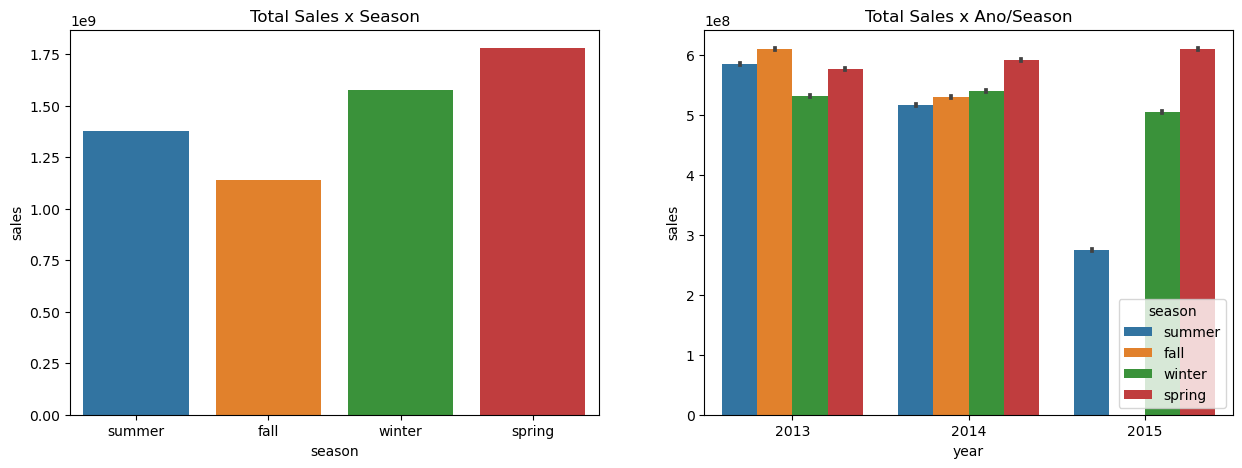

In [46]:
f = plt.figure(figsize=(15,5))

f.add_subplot(121)
sns.barplot(data=df4[['sales', 'season']].groupby('season').sum().reset_index(), x='season', y='sales', order=['summer','fall','winter','spring']).set(title='Total Sales x Season');

f.add_subplot(122)
sns.barplot(data=df4[['sales', 'season','year']], x='year', y='sales',hue='season',estimator= sum, hue_order=['summer','fall','winter','spring']).set(title='Total Sales x Ano/Season');

**Hipótese 2.** Ocorrem menos vendas no fim de semana.

**VERDADEIRA:** No primeiro gráfico de Total Sales x Dia da Semana vemos que temos uma tendencia de queda das vendas ao longo da semana com um novo pico no dia 5(Sexta), porém voltando a cair no dia 6 (Sábado) e tendo uma drástica queda no domingo. Porém no segundo gráfico, que se da pela média de vendas por dia da semana, o dia 7 (domingo), possui um pico de venda. Seria necessário uma verificação mais profunda para detectar o porque desse pico na média de vendas.

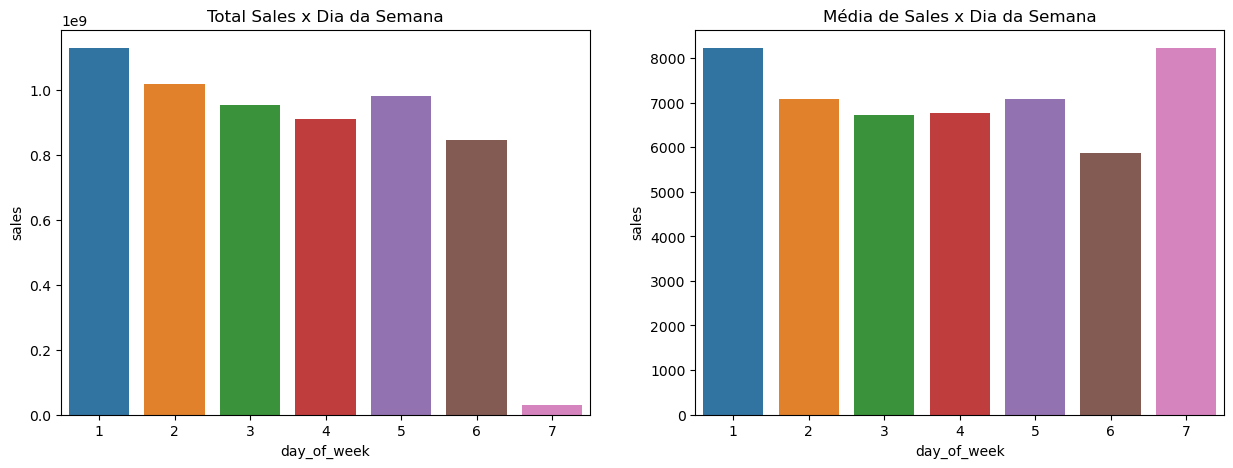

In [47]:
f = plt.figure(figsize=(15,5))

f.add_subplot(121)
sns.barplot(data=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index(),x='day_of_week',y='sales').set(title='Total Sales x Dia da Semana');

f.add_subplot(122)
sns.barplot(data=df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index(),x='day_of_week',y='sales').set(title='Média de Sales x Dia da Semana');

**Hipótese 3.** As vendas crescem anualmente.

**FALSA:** Apensar de não termos os dados completos de 2015, vemos uma queda das vendas de 2013 para 2014.

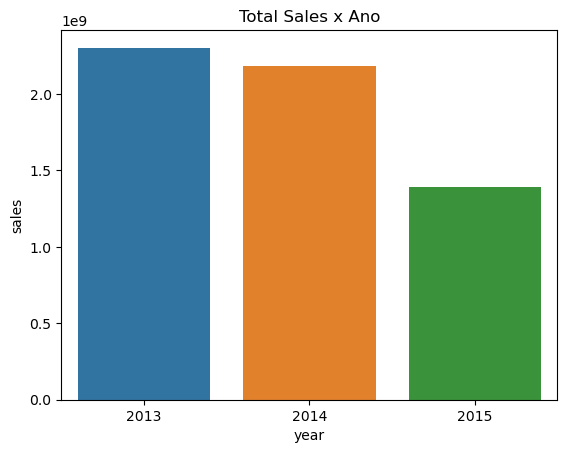

In [48]:
sns.barplot(data=df4[['year','sales']].groupby('year').sum().reset_index(),x='year',y='sales').set(title='Total Sales x Ano');


**Hipótese 4.** As vendas diminuem em feriados.

**FALSA:** Na média, as vendas em feriados são maiores que as vendas em dias normais da semana.

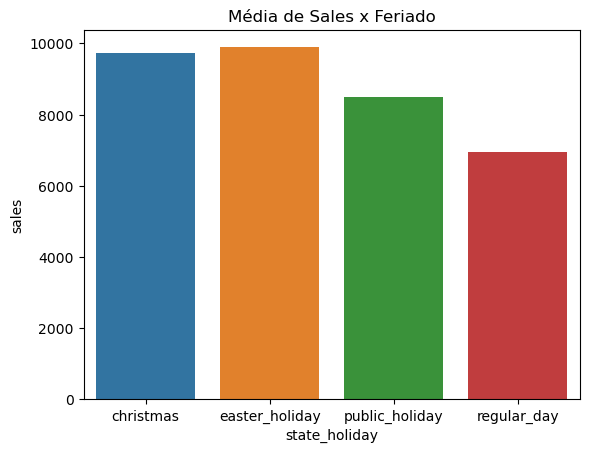

In [49]:
sns.barplot(data=df4[['sales','state_holiday']].groupby('state_holiday').mean().reset_index(),x='state_holiday',y='sales').set(title='Média de Sales x Feriado');

**Hipótese 5.** Lojas com itens em promoção vendem mais.

**VERDADEIRO:** As lojas quando estão em promoção possuem 

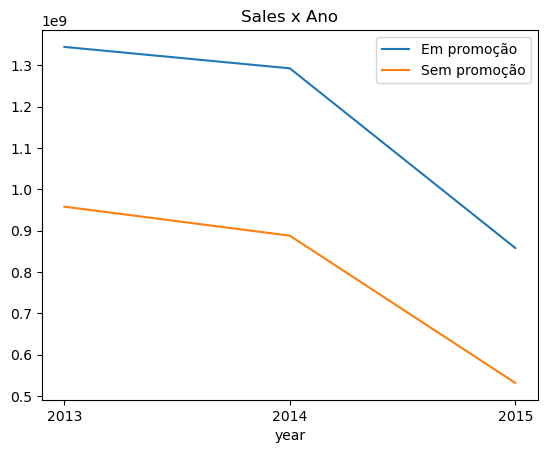

In [50]:
xnames= np.unique(df4['year']).tolist()
df_aux1 = df4[( df4['promo'] == 1 ) | ( df4['is_promo_2'] == 1 )][['year','sales']].groupby( 'year' ).sum()
ax = df_aux1.plot()
df_aux2 = df4[( df4['promo'] == 0 ) & ( df4['is_promo_2'] == 0 )][['year','sales']].groupby( 'year' ).sum()
df_aux2.plot( ax=ax )
ax.set_title(label="Sales x Ano")
ax.legend( labels=['Em promoção','Sem promoção'])
plt.xticks(xnames,xnames);

**Hipótese 6.** Lojas com promoções consecutivas vendem mais.

**FALSA:** As Lojas que participaram apenas da promoção tradicional venderam mais que as lojas  que participaram de ambas as promoções

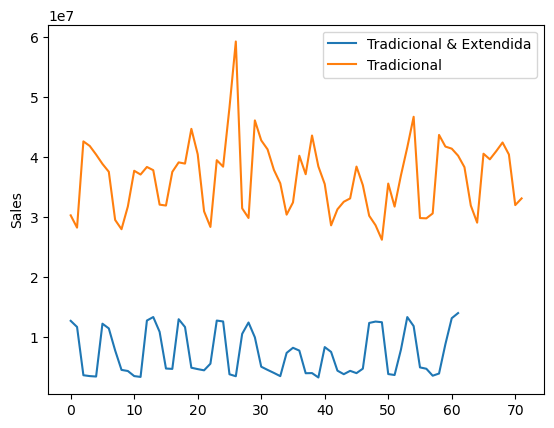

In [51]:
df_aux1 = df4[( df4['promo'] == 1 ) & ( df4['is_promo_2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = df_aux1.plot()
df_aux2 = df4[( df4['promo'] == 1 ) & ( df4['is_promo_2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
df_aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Tradicional'])
ax.set_ylabel('Sales');

**Hipótese 7.** Lojas com menor variedade de produtos vendem menos. _Hipótese alterada para tipo de Sortimento, devido aos dados que possuimos neste dataset._

**FALSA:** Lojas com sortimento basic vendem mais que lojas de outro tipo de sortimento

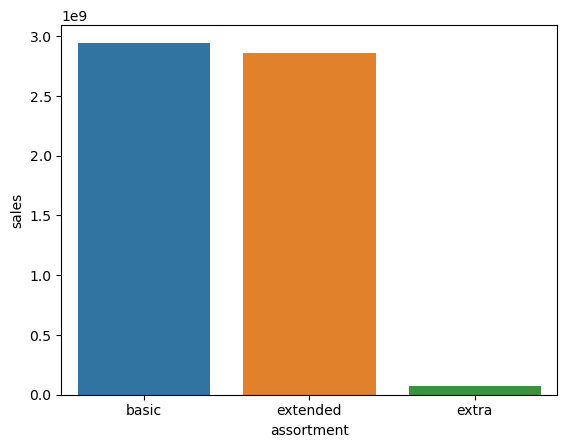

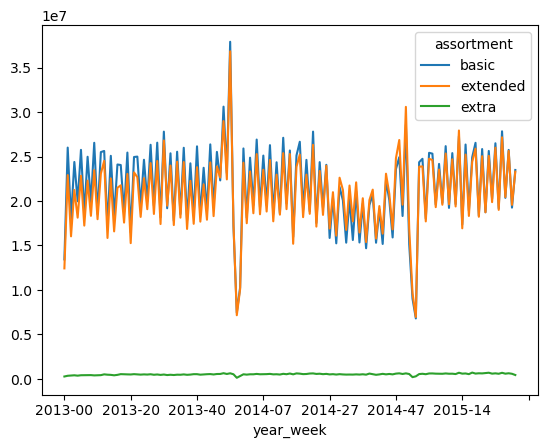

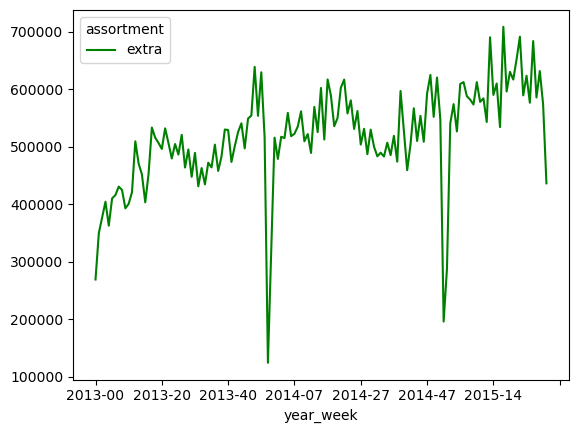

In [52]:
df_aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=df_aux1 );

df_aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
df_aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

df_aux3 = df_aux2[df_aux2['assortment'] == 'extra']
df_aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(color='g');

**Hipótese 8.** Lojas com concorrentes mais próximos vendem menos.

**FALSO:** Lojas com concorrentes mais próximos vendem mais

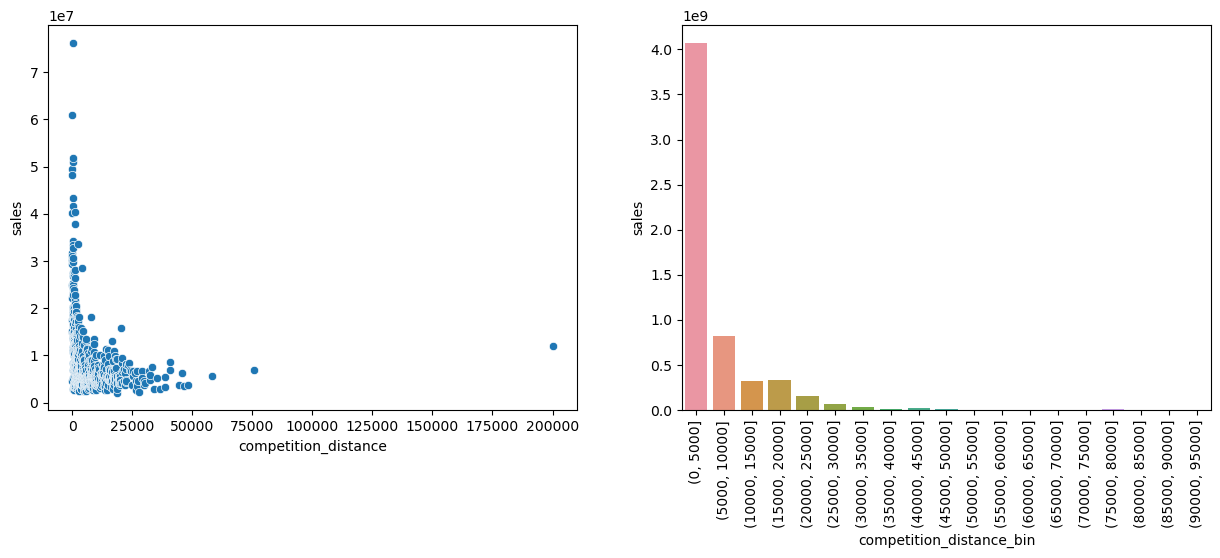

In [53]:
f = plt.figure(figsize=(15,5))
f.add_subplot(121)
df_aux1 = data=df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x='competition_distance', y='sales', data= df_aux1);


f.add_subplot(122)
bin = list( np.arange( 0, 100000, 5000) )
df_aux1['competition_distance_bin'] = pd.cut( df_aux1['competition_distance'],bins=bin )
sns.barplot( x='competition_distance_bin', y='sales', data= df_aux1[['competition_distance_bin', 'sales']].groupby( 'competition_distance_bin' ).sum().reset_index());
plt.xticks(rotation = 90);

**Hipótese 9.** Os tipos de loja influênciam na quantidade de vendas.

**VERDADEIRO:** A loja do tipo A vende muito mais que todas as outras lojas.

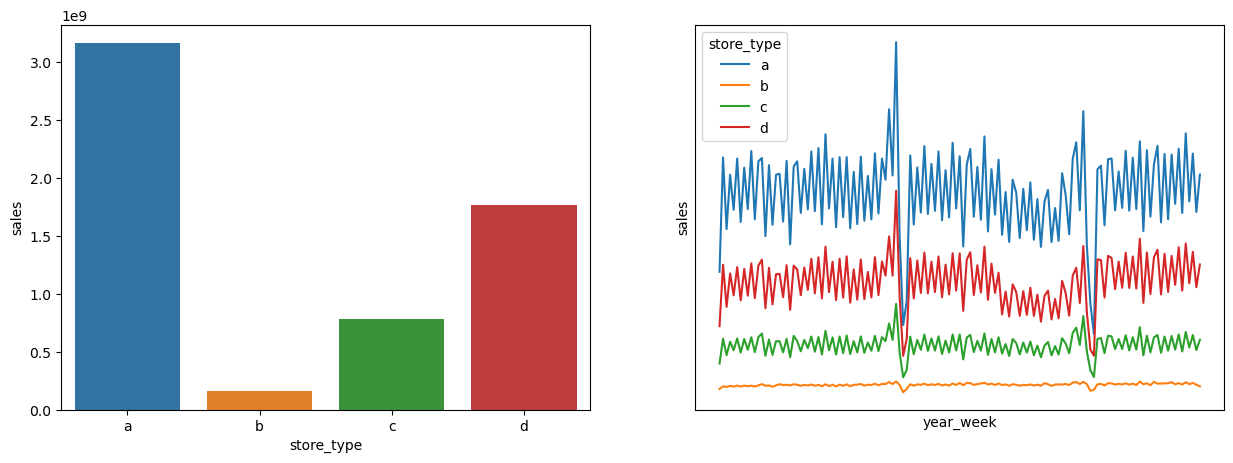

In [54]:
f = plt.figure(figsize=(15,5))
f.add_subplot(121)
df_aux1 = df4[['store_type', 'sales']].groupby( 'store_type' ).sum().reset_index()
sns.barplot( x='store_type', y='sales', data=df_aux1 );

f.add_subplot(122)
df_aux2 = df4[['year_week', 'store_type', 'sales']].groupby(['year_week','store_type'] ).sum().reset_index()
sns.lineplot(x='year_week', y='sales', hue='store_type',data=df_aux2);
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

**Hipótese 10.** Lojas com competidores à mais tempo deveriam vendem mais.

**FALSA:** As vendas caem quanto mais tempo existem um concorrente.

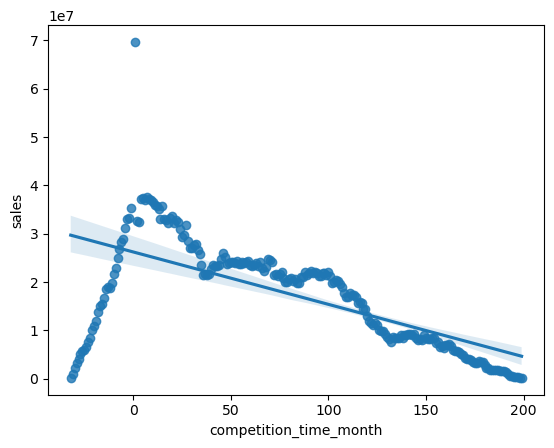

In [55]:
df_aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[( df_aux1['competition_time_month'] < 200 ) & (df_aux1['competition_time_month'] != 0 )]
sns.regplot( x='competition_time_month', y='sales', data=df_aux2 );

### 6.1 Análise Multivariada

#### 6.1.1 Númericos

In [26]:
numericos = df1.select_dtypes( include=['int64','int32','UInt32','float64'] )

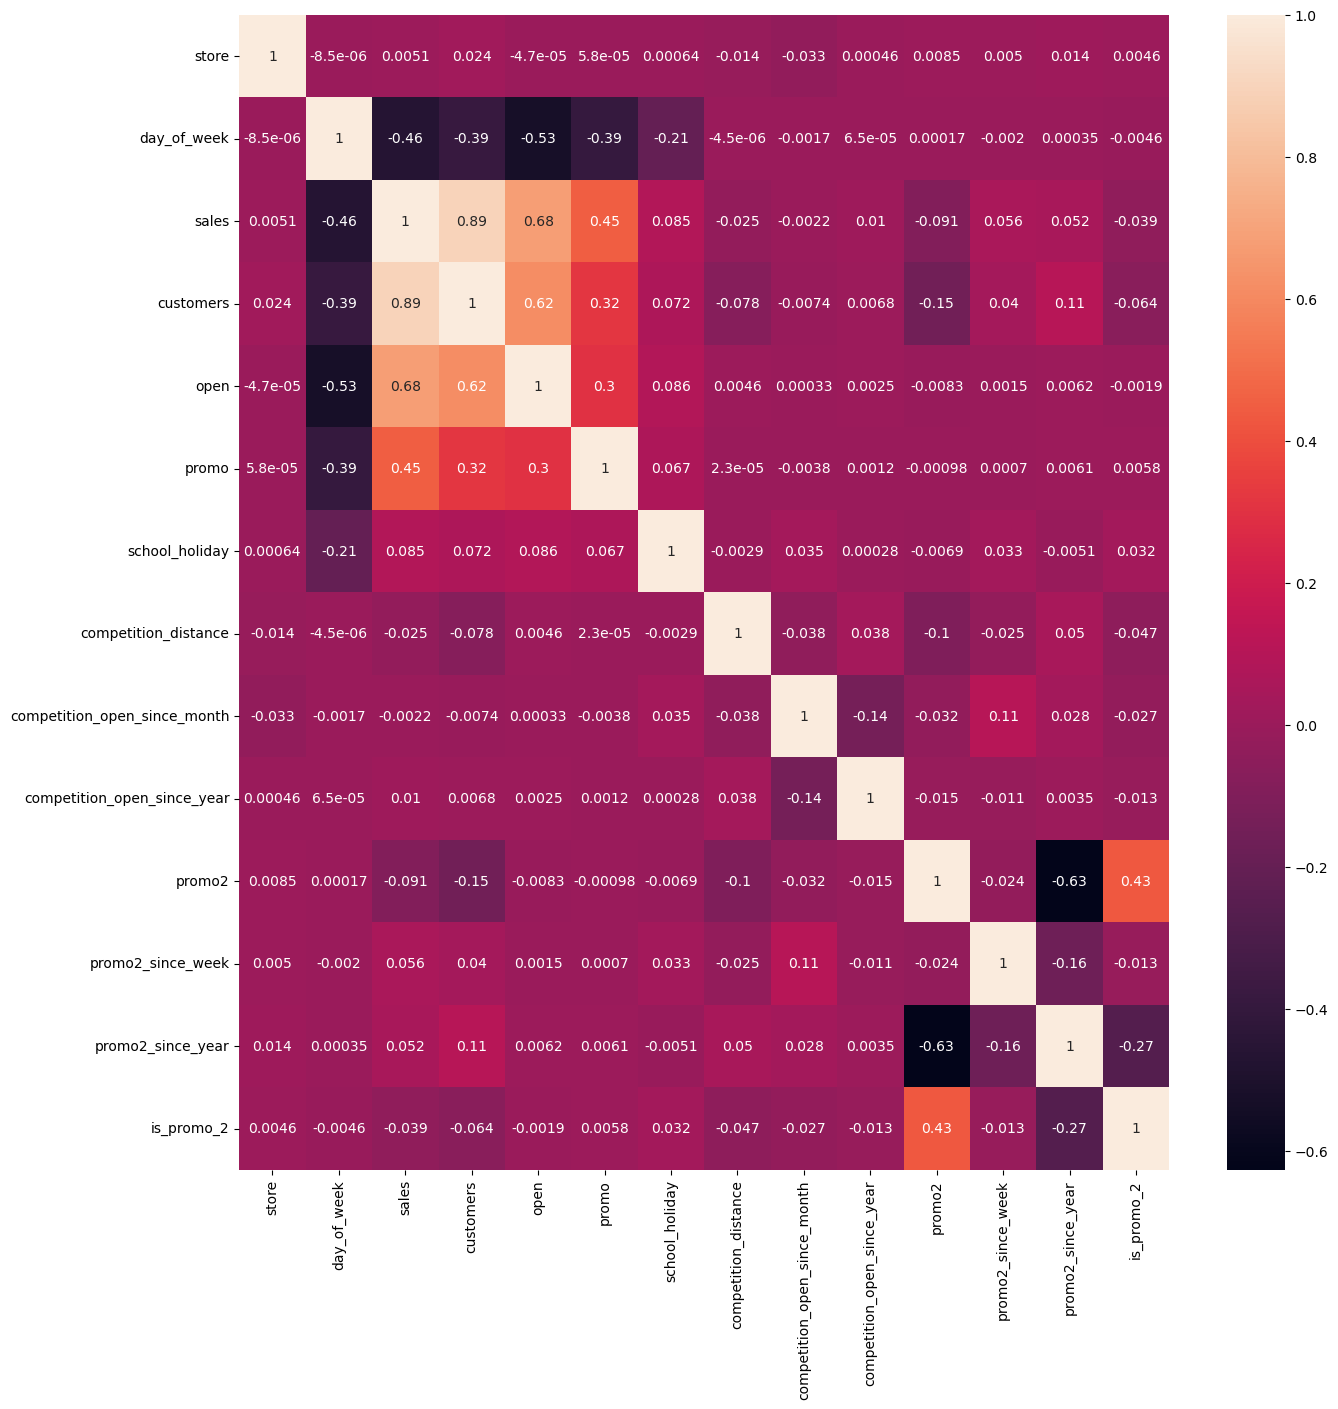

In [57]:
fig = plt.figure(figsize=[15,15])
fig = sns.heatmap(numericos.corr( method='pearson'), annot=True)

#### 6.1.1 Categóricos

In [58]:
categorico = df4.select_dtypes( include='object' )

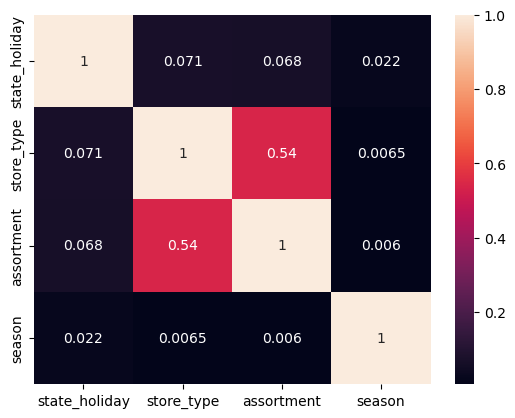

In [59]:
a1 = cramer_v( categorico['state_holiday'], categorico['state_holiday'] )
a2 = cramer_v( categorico['state_holiday'], categorico['store_type'] )
a3 = cramer_v( categorico['state_holiday'], categorico['assortment'] )
a4 = cramer_v( categorico['state_holiday'], categorico['season'] )


a5 = cramer_v( categorico['store_type'], categorico['state_holiday'] )
a6 = cramer_v( categorico['store_type'], categorico['store_type'] )
a7 = cramer_v( categorico['store_type'], categorico['assortment'] )
a8 = cramer_v( categorico['store_type'], categorico['season'] )


a9 = cramer_v( categorico['assortment'], categorico['state_holiday'] )
a10 = cramer_v( categorico['assortment'], categorico['store_type'] )
a11 = cramer_v( categorico['assortment'], categorico['assortment'] )
a12 = cramer_v( categorico['assortment'], categorico['season'] )


a13 = cramer_v( categorico['season'], categorico['state_holiday'] )
a14 = cramer_v( categorico['season'], categorico['store_type'] )
a15 = cramer_v( categorico['season'], categorico['assortment'] )
a16 = cramer_v( categorico['season'], categorico['season'] )

dfcor = pd.DataFrame( {'state_holiday': [a1, a2, a3, a4],'store_type': [a5, a6, a7, a8], 'assortment': [a9, a10, a11, a12], 'season': [a13, a14, a15, a16]})
dfcor = dfcor.set_index( dfcor.columns )
sns.heatmap( dfcor, annot=True );

## 7.0 Preparação dos Dados

In [27]:
df5 = df4.copy()

### 7.1 Normalização

In [61]:
#Não iremos normalizar nenhum dado, será aplicada o Rescaling ao invés.

### 7.2 Rescaling

In [28]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'competition_time_month_scaler.pkl', 'wb') ) 

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open( 'promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'year_scaler.pkl', 'wb') )

### 7.3 Transformação

#### 7.3.1 Encoding

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo_2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo_time_week,season
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,summer
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,summer
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,summer
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,summer
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,summer


In [29]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5,prefix='state_holiday',columns=['state_holiday'])


In [30]:
#store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'store_type_scaler.pkl', 'wb') )

In [31]:
#assortment -ordinal encoding
mapping = {"basic": 1,  "extra": 2, "extended": 3}
df5['assortment'] = df5['assortment'].map(mapping)

In [32]:
#season - ordinal encoding
mapping2 = {"winter": 1,  "spring": 2, "summer": 3, 'fall': 4}
df5['season'] = df5['season'].map(mapping2)

#### 7.3.2 Transformação de Grandeza - Variável Resposta

In [33]:
#Aplicando o logaritmo na variavel resposta
df5['sales'] = np.log1p(df5['sales'])

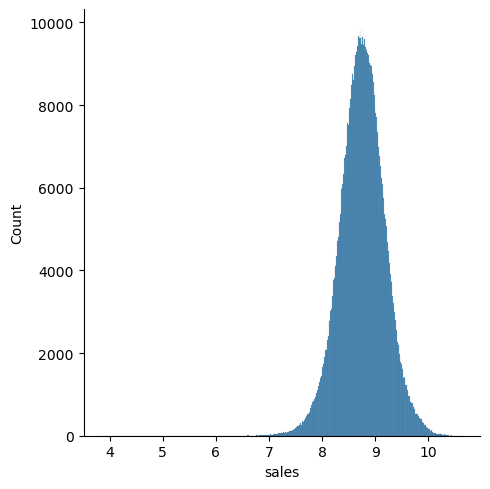

In [69]:
sns.displot(df5['sales'])

#### 7.3.3 Transformação de Natureza

In [34]:
 # day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 )))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.*np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.*np.pi/52 )))

# season
df5['season_sin'] = df5['season'].apply( lambda x: np.sin( x * (2.*np.pi/4 )))
df5['season_cos'] = df5['season'].apply( lambda x: np.cos( x * (2.*np.pi/4 )))

## 8.0 Seleção de Features

In [35]:
df6 = df5.copy()

In [36]:
#Drop de colunas que serviram para derivar outras features
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since','competition_since', 'year_week', 'season']
df6 = df6.drop( cols_drop, axis=1 )

In [37]:
# Dataset Treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Dataset Teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

np.float = float
np.bool = bool
np.int = int 

#Foi escolhido como teste todas as vendas realizadas nas ultimas 6 semanas que temos data. Uma vez que a ideia é prever um total de 6 semanas de venda.

In [74]:
# Retirando váriaveis data e vendas para utilizar o boruta

#X_train_out_sales = X_train.drop( ['date', 'sales'], axis=1 )

#X_train_n = X_train_out_sales.values
#y_train_n = y_train.values.ravel()

#RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


In [75]:
#cols_selected = boruta.support_.tolist()

# Melhores Features (Boruta)
#cols_selected_boruta = X_train_out_sales.iloc[:, cols_selected].columns.to_list()

# Features Rejeitadas (Boruta)
#cols_not_selected_boruta = list( np.setdiff1d( X_train_out_sales.columns,cols_selected_boruta ) )

### 8.1 Lista de Features Manual pós Boruta

In [38]:
#Adicionadas contra partes de cos/sin que o Boruta descartou e fazendo a lista manual para economizar tempo em uma nova Run do notebook

cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_cos',
                         'month_sin',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos']

# Adicionando colunas de data e da variavel resposta sales

features_add = ['date', 'sales']
cols_for_ml = cols_selected_boruta.copy()
cols_for_ml.extend( features_add )

## 9.0 Algoritmos de Machine Learning

In [39]:
x_treino = X_train[cols_selected_boruta]
y_treino = y_train
x_treino_full= X_train[cols_for_ml]

x_teste = X_test[cols_selected_boruta]
yteste = y_test

### 9.1 Modelo de Média

In [40]:
df_mean_model = x_teste.copy()
df_mean_model['sales'] = yteste.copy()

In [41]:
# Média de venda das ultimas 6 semanas

df_aux1 = df_mean_model[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'previsao'})
df_mean_model = pd.merge(df_mean_model,df_aux1, how = 'left', on= 'store')
yhat_base = df_mean_model['previsao']

In [42]:
# Performance da média
baseline_result = ml_error('Modelo de Média',np.expm1(yteste),np.expm1(yhat_base))
baseline_result

,Modelo,MAE,MAPE,RMSE
0,Modelo de Média,1354.800353,0.455051,1835.135542


### 9.2 Regressão Linear

In [122]:
#Definicao do Modelo  e Treino
lr = LinearRegression()
lr.fit(x_treino, y_treino)

LinearRegression()

In [123]:
#Previsao
y_hat_lr = lr.predict(x_teste)

In [124]:
#Previsao
lr_result = ml_error('Regressão Linear', np.expm1(yteste),np.expm1(y_hat_lr))
lr_result

,Modelo,MAE,MAPE,RMSE
0,Regressão Linear,1867.089774,0.292694,2671.049215


#### 9.2.1 Regressão Linear - Cross Validation

In [125]:
model = lr
lr_result_cv = cross_validation( x_treino_full, 5, "Regressão Linear",model, verbose=True )
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Regressão Linear,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 9.3 Regressão Regualrizada - Ridge

In [116]:
#Definicao do Modelo  e Treino
ridge = Ridge(alpha=10)
ridge.fit(x_treino, y_treino)

Ridge(alpha=10)

In [117]:
#Previsao
y_hat_ridge = ridge.predict(x_teste)

In [118]:
#Performance
ridge_result = ml_error('Regressão Linear - Ridge', np.expm1(yteste),np.expm1(y_hat_ridge))
ridge_result

,Modelo,MAE,MAPE,RMSE
0,Regressão Linear - Ridge,1867.227175,0.292692,2671.443804


#### 9.3.1 Regressão Regualrizada - Ridge - Cross Validation

In [126]:
model = ridge
ridge_result_cv = cross_validation( x_treino_full, 5, "Ridge",model, verbose=True )
ridge_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Ridge,2081.73 +/- 295.83,0.3 +/- 0.02,2952.7 +/- 468.51


### 9.4 Random Forest

In [87]:
#Definicao do Modelo  e Treino
rf = RandomForestRegressor(n_estimators = 100, n_jobs=1)
rf.fit(x_treino, y_treino)

RandomForestRegressor(n_jobs=1)

In [88]:
#Previsao
y_hat_rf = rf.predict(x_teste)

In [89]:
#Performance
rf_result = ml_error('Random Forest', np.expm1(yteste),np.expm1(y_hat_rf))
rf_result

,Modelo,MAE,MAPE,RMSE
0,Random Forest,682.605351,0.100469,1015.765468


#### 9.4.1 Random Forest - Cross Validation

In [133]:
model = rf
rf_result_cv = cross_validation( x_treino_full, 5, "Random Forest",model, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.27 +/- 216.74,0.12 +/- 0.02,1256.61 +/- 317.76


### 9.5 XGBoost

In [144]:
#Definicao do Modelo  e Treino
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100)
xgb_model.fit(x_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [145]:
#Previsao
y_hat_xgb_model = xgb_model.predict(x_teste)

In [146]:
#Performance
xgb_result = ml_error('XGBoost', np.expm1(yteste),np.expm1(y_hat_xgb_model))
xgb_result

,Modelo,MAE,MAPE,RMSE
0,XGBoost,868.958205,0.130309,1238.550843


#### 9.4.1 XGBoost - Cross Validation

In [127]:
model = xgb_model
xgb_result_cv = cross_validation( x_treino_full, 5, "XGBoost",model, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1063.51 +/- 178.21,0.15 +/- 0.02,1518.89 +/- 241.61


### 9.6 Performance - Treino/Teste

In [121]:
resultados_modelos = pd.concat([baseline_result,lr_result,ridge_result,rf_result,xgb_result])
resultados_modelos.sort_values('RMSE')

,Modelo,MAE,MAPE,RMSE
0,Random Forest,682.605351,0.100469,1015.765468
0,XGBoost,868.958205,0.130309,1238.550843
0,Modelo de Média,1354.800353,0.455051,1835.135542
0,Regressão Linear,1867.089774,0.292694,2671.049215
0,Regressão Linear - Ridge,1867.227175,0.292692,2671.443804


### 9.7 Performance Cross Validation

In [134]:
resultados_modelos_cv = pd.concat([lr_result_cv,ridge_result_cv,rf_result_cv,xgb_result_cv])
resultados_modelos_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Regressão Linear,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Ridge,2081.73 +/- 295.83,0.3 +/- 0.02,2952.7 +/- 468.51
0,Random Forest,837.27 +/- 216.74,0.12 +/- 0.02,1256.61 +/- 317.76
0,XGBoost,1063.51 +/- 178.21,0.15 +/- 0.02,1518.89 +/- 241.61


##### Optaremos por usar o XGBoost apesar de não ter o melhor resultado. Em um próximo ciclo do CRISP podemos alterar testar novos algoritmos e verficar a performance.

## 10.0 Fine-Tuning

### 10.1 Random Search

In [180]:
#p = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
#    'eta':[0.01,0.03],
#    'max_depth':[3,5,10],
#    'subsample':[0.1, 0.5, 0.8],
#    'colsample_bytree':[0.2, 0.6, 0.9],
#    'min_child_weight':[3, 7, 14]}
#
#max_inte = 10

In [182]:
#tunning_result = pd.DataFrame()
#
#for i in range (max_inte):
#    #Random Sample
#    ft = { k: random.sample( v, 1 )[0] for k, v in p.items() }
#    print(ft)
#    
#    #Definicao do Modelo  e Treino
#    xgb_model_tune = xgb.XGBRegressor(objective ='reg:squarederror', 
#                                 booster = 'gbtree',
#                                 n_jobs= -1,
#                                 n_estimators = ft ['n_estimators'],
#                                 eta= ft ['eta'], 
#                                 max_depth= ft ['max_depth'],
#                                 subsample= ft ['subsample'],
#                                 colsample_bytree= ft ['colsample_bytree'],
#                                 min_child_weight= ft ['min_child_weight']
#                                 )
#    #Resultados
#    result = cross_validation( x_treino_full, 5, "XGBoost",xgb_model_tune, verbose=True )
#    tunning_result = pd.concat( [tunning_result, result] )
#

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 7}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.2, 'min_child_weight': 7}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.2, 'min_child_weight': 7}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 

In [183]:
tunning_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,780.49 +/- 138.86,0.11 +/- 0.01,1138.12 +/- 207.01
0,XGBoost,792.46 +/- 132.42,0.11 +/- 0.01,1155.34 +/- 196.95
0,XGBoost,1030.59 +/- 128.19,0.14 +/- 0.01,1491.42 +/- 191.38
0,XGBoost,1109.08 +/- 117.31,0.15 +/- 0.01,1583.68 +/- 162.8
0,XGBoost,818.76 +/- 131.3,0.12 +/- 0.01,1177.65 +/- 191.59
0,XGBoost,902.48 +/- 118.45,0.12 +/- 0.01,1294.61 +/- 185.02
0,XGBoost,1486.97 +/- 158.68,0.21 +/- 0.01,2155.35 +/- 209.74
0,XGBoost,1774.61 +/- 191.59,0.25 +/- 0.01,2545.61 +/- 256.58
0,XGBoost,966.4 +/- 123.25,0.13 +/- 0.01,1393.61 +/- 188.8
0,XGBoost,1615.6 +/- 171.35,0.22 +/- 0.01,2330.23 +/- 234.95


### 10.2 Modelo otimizado

In [45]:
 p_tunned = {
'n_estimators': 1500,
'eta': 0.03,
'max_depth': 10,
'subsample': 0.8,
'colsample_bytree': 0.6,
'min_child_weight': 3
}

In [46]:
#Definicao do Modelo  e Treino
xgb_tuned = xgb.XGBRegressor(objective ='reg:squarederror', 
                                  booster = 'gbtree',
                                  n_jobs= -1,
                                  n_estimators = p_tunned ['n_estimators'],
                                  eta= p_tunned ['eta'], 
                                  max_depth= p_tunned ['max_depth'],
                                  subsample= p_tunned ['subsample'],
                                  colsample_bytree= p_tunned ['colsample_bytree'],
                                  min_child_weight= p_tunned ['min_child_weight']
                                  )

xgb_tuned.fit(x_treino, y_treino)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=1500, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [47]:
#Previsao
y_hat_xgb_tuned = xgb_tuned.predict(x_teste)

In [48]:
#Performance
xgb_tuned_result = ml_error('XGBoost Tuned', np.expm1(yteste),np.expm1(y_hat_xgb_tuned))
xgb_tuned_result

,Modelo,MAE,MAPE,RMSE
0,XGBoost Tuned,636.882697,0.092537,930.398704


In [190]:
#Salvando Modelo
pickle.dump(xgb_tuned, open('xgb_tuned.pkl', 'wb'))

## 11.0 Tradução e interpretação do erro

In [101]:
df11 = X_test[cols_for_ml].copy()

In [102]:
# rescale da váriavel resposta para efetuar análise
df11['sales'] = np.expm1( df11['sales'] )
df11['predictions'] = np.expm1( y_hat_xgb_tuned )
df11['baseline'] = np.expm1(yhat_base)

### 11.1 Performance - Loja a loja

In [103]:
# Previsão total das 6 semanas
df11_grouped = df11[['store', 'predictions', 'sales', 'baseline']].groupby('store').sum().reset_index()

# MAE and MAPE
df11_aux1 = df11[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df11_aux2 = df11[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df11_aux3 = pd.merge( df11_aux1, df11_aux2, how='inner', on='store')
df_performance = pd.merge( df11_grouped, df11_aux3, how='inner', on='store' )

# Cenarios
df_performance['pior_cenario'] = df_performance['predictions'] - df_performance['MAE']
df_performance['melhor_cenario'] = df_performance['predictions'] + df_performance['MAE']

# Ordenando Colunas
df_performance = df_performance[['store', 'sales', 'baseline','predictions', 'pior_cenario', 'melhor_cenario', 'MAE','MAPE']]


In [105]:
df_performance.sort_values("MAPE", ascending = False).head(10).reset_index()

,index,store,sales,baseline,predictions,pior_cenario,melhor_cenario,MAE,MAPE
0,291,292,137966.0,85485.949826,104446.953125,101107.417095,107786.489155,3339.536030,0.558511
1,908,909,360069.0,120824.083739,234994.890625,227414.063349,242575.717901,7580.827276,0.512176
2,875,876,257556.0,136203.645504,204859.656250,200902.569697,208816.742803,3957.086553,0.300091
3,594,595,529213.0,222774.927030,390479.000000,386729.432261,394228.567739,3749.567739,0.258613
4,721,722,279296.0,205762.363648,341677.750000,339991.756572,343363.743428,1685.993428,0.226397
5,971,972,120757.0,215628.891052,147356.468750,146596.338936,148116.598564,760.129814,0.224447
6,273,274,253372.0,241618.906407,199531.796875,198279.699031,200783.894719,1252.097844,0.215999
7,781,782,197866.0,245878.688288,210760.671875,210067.395930,211453.947820,693.275945,0.202955
8,533,534,283909.0,225704.935999,280989.375000,279671.230165,282307.519835,1318.144835,0.202830
9,955,956,113876.0,203723.870594,128779.625000,128265.821408,129293.428592,513.803592,0.194406


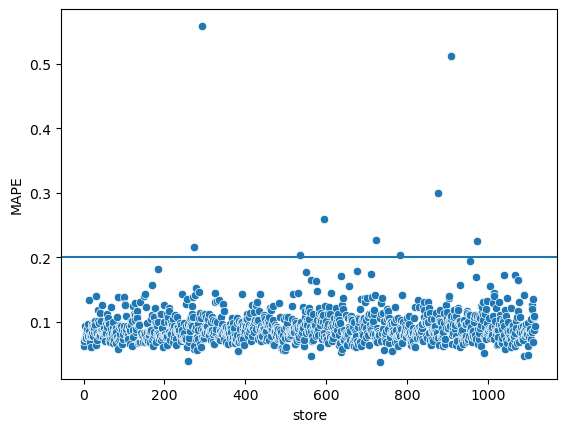

In [55]:
graph =sns.scatterplot( x='store', y='MAPE', data=df_performance )
graph.axhline(0.2)

#### Como podemos ver existem 9 lojas com MAPE maior do que 20%, e 3 casos especiais com MAPE acima de 30%, o ideal seria que no próximo ciclo do CRISP realizemos um estudo melhor dessas lojas, tentando colocar mais váriaveis para o modelo ou fazer um modelo apenas para essas lojas e buscar o entendimento do porque essas lojas tem maior dificuldade de previsão.

### 11.2 Performance Total

In [106]:
df_total = df_performance[['baseline', 'sales','predictions', 'pior_cenario', 'melhor_cenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Cenario', 0:'Valores'} )
df_total['Valores'] = df_total['Valores'].map( 'R${:,.2f}'.format )
df_total

,Cenario,Valores
0,baseline,"R$243,723,748.12"
1,sales,"R$289,571,750.00"
2,predictions,"R$283,633,024.00"
3,pior_cenario,"R$282,918,700.01"
4,melhor_cenario,"R$284,347,360.93"


In [110]:
df_performance[['baseline', 'sales','predictions', 'pior_cenario', 'melhor_cenario']].sum()

baseline          2.437237e+08
sales             2.895718e+08
predictions       2.836330e+08
pior_cenario      2.829187e+08
melhor_cenario    2.843474e+08
dtype: float64

### 11.3 Performance do Modelo

In [250]:
df11['error'] = df11['sales'] - df11['predictions']
df11['error_rate'] = df11['predictions'] / df11['sales']

<Axes: xlabel='predictions', ylabel='error'>

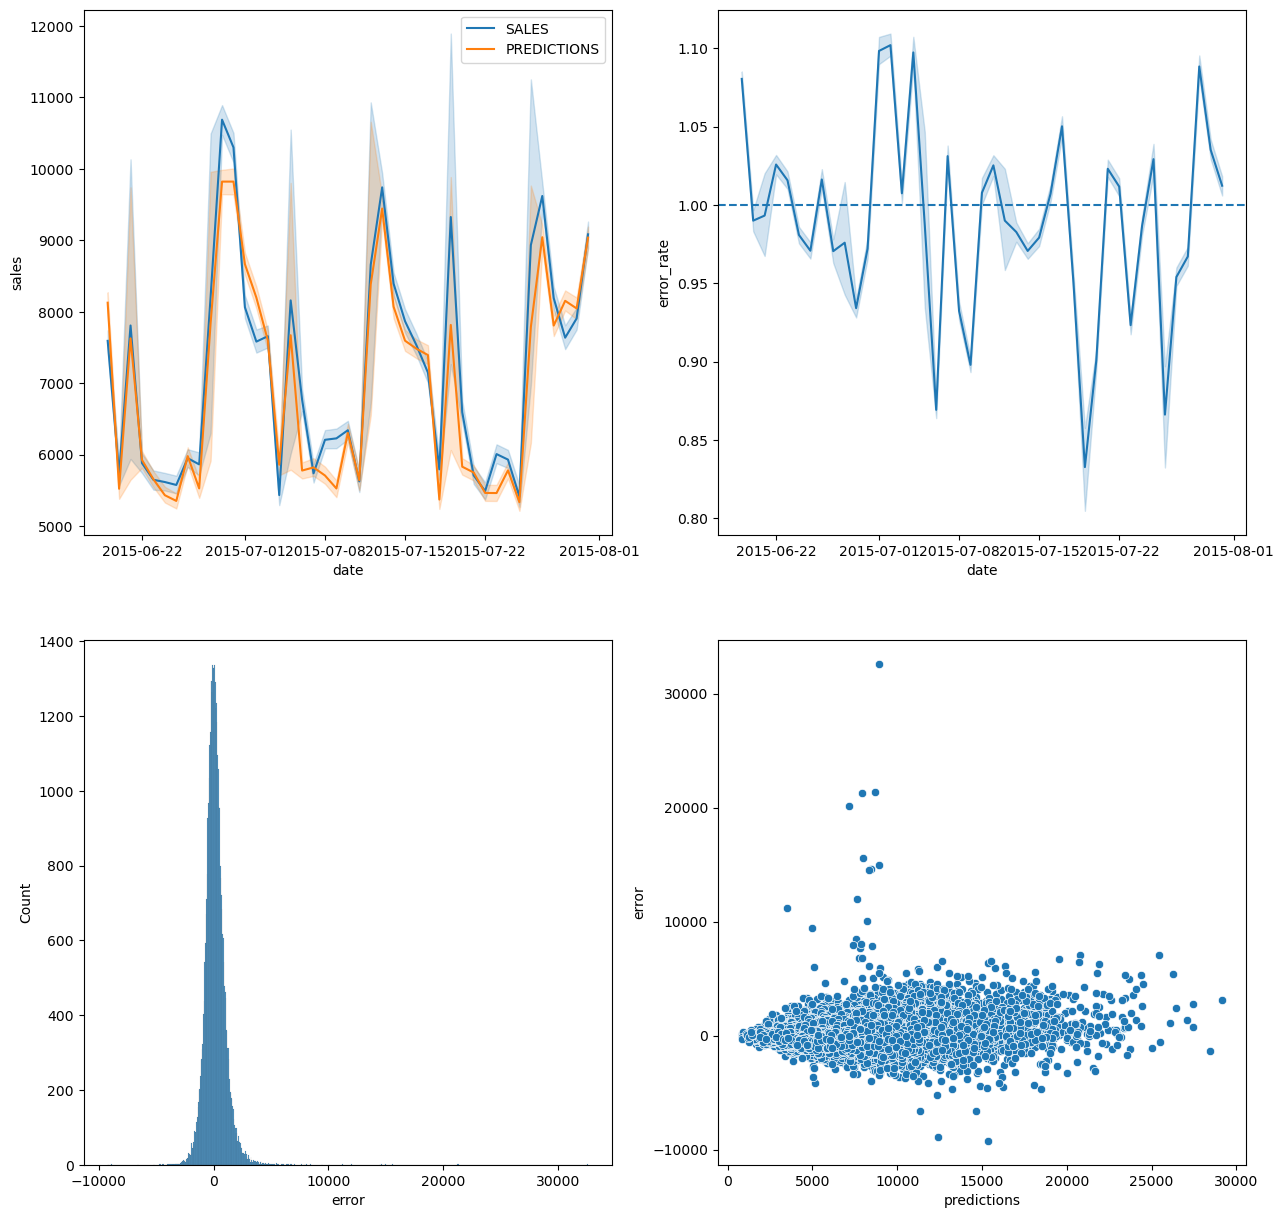

In [279]:
f = plt.figure(figsize=(15,15))

ax1 = f.add_subplot(221)
sns.lineplot( x='date', y='sales', data=df11, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df11, label='PREDICTIONS' )

ax2 = f.add_subplot(222)
sns.lineplot( x='date', y='error_rate', data=df11 )
plt.axhline( 1, linestyle='--')

ax3 = f.add_subplot(223)
sns.histplot( df11['error'] )

ax4 = f.add_subplot(224)
sns.scatterplot( x = df11['predictions'], y = df11['error'] )



## 12.0 Deploy

### 12.1 Rossmann Class

In [344]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/Users/Rafael/Desktop/Programacao/repos/rossmann_store/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'store_type_scaler.pkl', 'rb') )
        
    def data_cleaning( self, df1 ):
        #3.1 Renomear Colunas
        old_cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
        'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x:inflection.underscore(x)
        new_cols = list(map(snakecase, old_cols))
        df1.columns = new_cols
        
        #Convertendo data
        df1['date'] = pd.to_datetime(df1['date'])
        
        #3.3 Preenchimento dos NA
        #competition_distance: A premissa adotada é que  não existem competidores próximos da loja, de forma que substituiremos 
        #os valores NA por valores muito altos
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if pd.isna(x) else x)

        #competition_open_since_month: A premissa adotada é manter as linhas NA, porém usar o mês da venda daquela loja como data da
        # abertura da concorrente.
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year: A premissa adotada é manter as linhas NA, porém usar o mês da venda daquela loja como data da
        # abertura da concorrente.
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo_2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        #Convertendo tipo de dado
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering( self, df2 ):
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week_of_year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        #year_week
        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

        #competition_since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

        #promo2_since
        df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        #state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        #season
        spring = range(79, 172)
        summer = range(172, 266)
        fall = range(266, 355)
        df2['season'] = df2['date'].apply(lambda x: 'spring' if x.timetuple().tm_yday in spring else 'summer' if x.timetuple().tm_yday in summer else 'fall' if x.timetuple().tm_yday in fall else 'winter' )
        
        ## 5.0 Filtragem de Variáveis 
        #Filtrando linhas onde a loja está fechada e também onde as vendas foram 0
        df2 = df2[(df2['open'] != 0)]
        
        #Filtrando colunas que não teremos no momento da previsão ou que foram colunas auxiliares na criação de váriaveis
        df2 = df2.drop(['open','promo_interval','month_map'], axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
        ### 7.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        #### 7.3.1 Encoding
        #state_holiday - one hot encoding
        df5 = pd.get_dummies(df5,prefix='state_holiday',columns=['state_holiday'])
        
        #store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        #assortment -ordinal encoding
        mapping = {"basic": 1,  "extra": 2, "extended": 3}
        df5['assortment'] = df5['assortment'].map(mapping)
        
        #season - ordinal encoding
        mapping2 = {"winter": 1,  "spring": 2, "summer": 3, 'fall': 4}
        df5['season'] = df5['season'].map(mapping2)
        
        #### 7.3.3 Transformação de Natureza
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 )))

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 )))
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 )))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.*np.pi/52 )))
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.*np.pi/52 )))

        # season
        df5['season_sin'] = df5['season'].apply( lambda x: np.sin( x * (2.*np.pi/4 )))
        df5['season_cos'] = df5['season'].apply( lambda x: np.cos( x * (2.*np.pi/4 )))
        
        cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                         'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                         'month_cos','month_sin','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # Previsão
        pred = model.predict( test_data )
        
        # Colocando a previsão no dataframe original
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

### 12.2  API Handler

In [299]:
import pickle
import pandas as pd

from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Carregar modelo de ML
model = pickle.load( open( '/Users/Rafael/Desktop/Programacao/repos/rossmann_store/xgb_tuned.pkl', 'rb') )

# Inicializar API com flask
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response

    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

### 12.2  API Tester

In [405]:
# Carregar dados de teste
df10 = pd.read_csv( '/Users/Rafael/Desktop/Programacao/repos/rossmann_store/data/test.csv' )

In [406]:
# Merge do teste com as stores
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Escolha das lojas
df_test = df_test[df_test['Store'].isin( [456, 325, 69] )]

# excluindo lojas fechadas
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [407]:
# Convertendo o arquivo para Json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [408]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://api-rossmann-store.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [409]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [410]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

Store Number 69 will sell R$354,592.15 in the next 6 weeks
Store Number 325 will sell R$243,438.95 in the next 6 weeks
Store Number 456 will sell R$267,958.78 in the next 6 weeks
